In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
from nltk.corpus import stopwords

# Load data
# Load data
data = pd.read_csv("data/updatemergedata.csv")
data.head()

# Encode categorical variables
label_encoder = LabelEncoder()
data['Level'] = label_encoder.fit_transform(data['Level']) 
data['Price'] = data['Price'].map({'Berbayar': 1, 'Gratis': 0})

# 1. Gabungkan fitur teks menjadi satu kolom
indonesian_stopwords = stopwords.words('indonesian')
numerical_features = data[['Level', 'Price']].values
data['Combined Summary'] = data['Learning Path'] + ' ' + data['Learning Path Summary'] + ' ' + data['Course Name_x'] + ' ' + data['Course Summary']

# 2. TF-IDF untuk fitur teks
tfidf = TfidfVectorizer(stop_words=indonesian_stopwords)
tfidf_matrix = tfidf.fit_transform(data['Combined Summary']).toarray()

# 3. Scaling data untuk fitur numerik jika diperlukan
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_matrix)
X_combined = np.hstack((X_scaled, numerical_features))  # Combine text and numeric features



C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [56]:
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)
print("Shape of numerical features:", numerical_features.shape)
print("Shape of combined data:", X_combined.shape)
# Check the shape of X_combined to ensure it's (n_samples, 412)
print(X_combined.shape)  # Should output (n_samples, 412)




Shape of TF-IDF matrix: (6039, 409)
Shape of numerical features: (6039, 2)
Shape of combined data: (6039, 411)
(6039, 411)


In [170]:

# 1. Tentukan dimensi input
input_dim = X_combined.shape[1]

# 2. Definisikan model Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64)(input_layer)
encoded = LeakyReLU(negative_slope=0.5)(encoded)
encoded = Dense(32)(encoded)
encoded = LeakyReLU(negative_slope=0.5)(encoded)

decoded = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.1))(encoded)
decoded = LeakyReLU(negative_slope=0.3)(decoded)
decoded = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.1))(decoded)
decoded = LeakyReLU(negative_slope=0.3)(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)


# 3. Compile model
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',  metrics=['accuracy'])

# 4. Early stopping untuk menghindari overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
print("Shape of X_combined:", X_combined.shape)
# 5. Train model
history = autoencoder.fit(
    X_combined, X_combined,  # Gunakan data gabungan sebagai input dan target
    epochs=100,
    batch_size=1028,
    shuffle=True,
    validation_split=0.4,
    callbacks=[early_stopping]
)

encoder = Model(inputs=input_layer, outputs=encoded)  # Extract the encoder part
encoder.save("encoder_only.keras")


Shape of X_combined: (6039, 411)
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 5.5203e-04 - loss: 13.6720 - val_accuracy: 0.0000e+00 - val_loss: 13.4053
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0422 - loss: 12.8841 - val_accuracy: 0.0459 - val_loss: 12.6643
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0187 - loss: 12.1286 - val_accuracy: 0.0459 - val_loss: 11.9605
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 11.3961 - val_accuracy: 0.0000e+00 - val_loss: 11.2950
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 10.6926 - val_accuracy: 0.0000e+00 - val_loss: 10.6677
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 10.0319 - val_accuracy: 0.0000e+00 - val_loss: 10.0769
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 9.4088 - val_accuracy: 0.0000e+00 - val_loss: 9.5197
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━

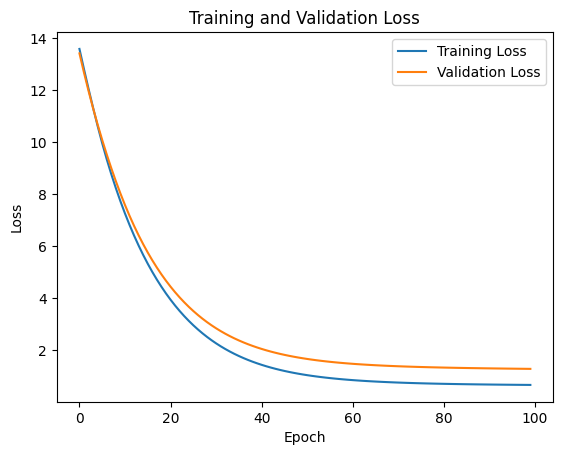

In [171]:
import matplotlib.pyplot as plt

# Plotting the loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [172]:
def recommend_learning_paths_with_encoder(data, encoder, user_preferences, programming_languages, github_username, min_courses=5):
    # Gabungkan preferensi pengguna ke dalam satu string
    user_vector = ' '.join(user_preferences + programming_languages + [github_username])
    
    # Transformasi ke TF-IDF
    user_vector_tfidf = tfidf.transform([user_vector]).toarray()
    
    # Gabungkan dengan fitur numerik dummy (contoh: 0 untuk level dan harga)
    user_vector_combined = np.hstack((user_vector_tfidf, [[0, 0]]))
    
    # Representasi ruang laten menggunakan encoder
    latent_user_vector = encoder.predict(user_vector_combined)
    latent_learning_paths = encoder.predict(X_combined)
    
    # Hitung kemiripan kosinus
    similarities = cosine_similarity(latent_user_vector, latent_learning_paths)[0]
    
    # Ambil top-n rekomendasi berdasarkan nilai kemiripan tertinggi
    top_indices = similarities.argsort()[::-1]
    recommendations = data.iloc[top_indices][['Course Name_x', 'Combined Summary']].copy()
    recommendations['similarity'] = similarities[top_indices]
    
    # Filter kursus unik
    unique_courses = recommendations.drop_duplicates(subset='Course Name_x')
    
    # Pilih minimal 5 kursus unik atau fallback ke top 5
    if len(unique_courses) >= min_courses:
        top_courses = unique_courses.head(min_courses)
    else:
        top_courses = recommendations.head(min_courses)
    
    # Penjelasan rekomendasi
    explanations = [
        f"Rekomendasi '{row['Course Name_x']}' memiliki kemiripan tinggi berdasarkan preferensi Anda."
        for _, row in top_courses.iterrows()
    ]
    
    return top_courses, explanations


In [182]:
import requests

# Ambil repositori GitHub pengguna
def get_github_repos(username):
    url = f'https://api.github.com/users/{username}/repos'
    response = requests.get(url)
    if response.status_code == 200:
        return [repo['language'] for repo in response.json() if repo['language']]  # Ambil bahasa pemrograman
    return []

# Rekomendasikan kursus berdasarkan preferensi dan bahasa GitHub
def recommend_learning_paths(data, encoder, user_preferences, programming_languages, github_username):
    github_languages = get_github_repos(github_username)
    preferences = user_preferences + programming_languages + github_languages
    return recommend_learning_paths_with_encoder(data, encoder, preferences, programming_languages, github_username)

# Gunakan fungsi untuk mendapatkan rekomendasi
user_preferences = [ 'Machine Learning', 'Design', 'CNN', 'Database']
programming_languages = ['Python', 'Javascript']
github_username = ''  # Ganti dengan username GitHub pengguna

recommendations, explanations = recommend_learning_paths(data, encoder, user_preferences, programming_languages, github_username)

# Tampilkan hasil
print("\nTop Recommended Course:")
print(recommendations)

print("\nExplanation for Recommendations:")
for explanation in explanations:
    print(explanation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Top Recommended Course:
                                          Course Name_x  \
4976               Belajar Dasar Pemrograman JavaScript   
3925                  Memulai Pemrograman dengan Python   
524   Cloud Practitioner Essentials (Belajar Dasar A...   
3422                   Memulai Pemrograman Dengan Swift   
3937              Belajar Machine Learning untuk Pemula   

                                       Combined Summary  similarity  
4976  React Developer Kurikulum lengkap yang didesai...    0.912438  
3925  Machine Learning Engineer Kurikulum lengkap ya...    0.845820  
524   Back-End Developer JavaScript Kurikulum disusu...    0.769306  
3422  iOS Developer Kurikulum disusun oleh Dicoding ...    0.741960  
3937  Machine Learning Engineer Kurikulum lengkap ya...    0.709256  

Explanation for Recommendations:
Rekomendasi 'Belajar Dasar Pemrograman JavaScript' memiliki kemiripan tinggi berdasarka

In [60]:
def get_top_recommendations(latent_user_vector, latent_learning_paths, data, min_courses=5):
    """
    Mendapatkan rekomendasi kursus berdasarkan vektor laten dan filter kursus unik.

    Args:
    - latent_user_vector: Vektor laten pengguna.
    - latent_learning_paths: Vektor laten semua kursus.
    - data: Data kursus asli (DataFrame).
    - min_courses: Jumlah minimal kursus unik.

    Returns:
    - recommendations: DataFrame dengan kursus yang direkomendasikan.
    - explanations: Penjelasan untuk rekomendasi.
    """
    # Hitung kemiripan kosinus
    similarities = cosine_similarity(latent_user_vector, latent_learning_paths).flatten()

    # Tambahkan kemiripan ke data asli
    data['similarity'] = similarities

    # Urutkan berdasarkan skor kemiripan
    sorted_data = data.sort_values(by='similarity', ascending=False)

    # Pilih kursus unik
    unique_courses = sorted_data.drop_duplicates(subset='Course Name_x')

    # Ambil minimal 5 kursus unik atau fallback ke 5 teratas
    if len(unique_courses) >= min_courses:
        top_courses = unique_courses.head(min_courses)
    else:
        top_courses = sorted_data.head(min_courses)

    # Penjelasan rekomendasi
    explanations = []
    for _, row in top_courses.iterrows():
        explanation = (
            f"Rekomendasi '{row['Course Name_x']}' memiliki kemiripan tinggi "
            f"dengan preferensi Anda berdasarkan vektor laten."
        )
        explanations.append(explanation)

    return top_courses[['Course Name_x', 'similarity']], explanations


In [6]:
import requests

def get_github_skills(username):
    # Ambil bahasa pemrograman dominan dari profil GitHub
    url = f"https://api.github.com/users/ricomessi/repos"
    response = requests.get(url)
    repos = response.json() if response.status_code == 200 else []

    languages = []
    for repo in repos:
        language_url = repo.get('languages_url')
        if language_url:
            lang_response = requests.get(language_url)
            lang_data = lang_response.json() if lang_response.status_code == 200 else {}
            languages.extend(lang_data.keys())

    return list(set(languages))  # Mengambil bahasa unik

def recommend_learning_paths(data, user_preferences, programming_languages, github_username=None):
    # Ambil skill dari GitHub jika tersedia
    github_languages = get_github_skills(github_username) if github_username else []
    combined_preferences = user_preferences + programming_languages + github_languages
    
    # Buat vector user preferences
    user_vector = " ".join(combined_preferences)
    vectorizer = TfidfVectorizer(stop_words=indonesian_stopwords)
    
    # Gabungkan data learning path dan user preferences
    all_vectors = vectorizer.fit_transform(data['Combined Summary'].tolist() + [user_vector])
    user_vector_tfidf = all_vectors[-1]
    learning_paths_vectors = all_vectors[:-1]
    
    # Hitung kemiripan antara user preferences dan learning paths
    similarity_scores = cosine_similarity(user_vector_tfidf, learning_paths_vectors)
    data['similarity'] = similarity_scores.flatten()

    # Filter rekomendasi berdasarkan nilai kemiripan minimal 0.4
    filtered_recommendations = data[data['similarity'] >= 0.4].sort_values(by='similarity', ascending=False)
    
    # Jika ada kurang dari 5 yang memenuhi kriteria, ambil 5 teratas meskipun kurang dari 0.4
    if len(filtered_recommendations) < 5:
        recommendations = data.sort_values(by='similarity', ascending=False).drop_duplicates(subset=['Course Name_x']).head(5)
    else:
        recommendations = filtered_recommendations.drop_duplicates(subset=['Course Name_x']).head(5)

    # Jelaskan alasan rekomendasi
    explanations = []
    for _, row in recommendations.iterrows():
        explanations.append(
            f"Rekomendasi '{row['Course Name_x']}' memiliki kemiripan tinggi dengan preferensi Anda "
            f"berdasarkan skill '{user_preferences}', bahasa pemrograman '{programming_languages}', dan aktivitas GitHub '{github_languages}'.")

    return recommendations[['Course Name_x', 'similarity']], explanations

# Contoh Penggunaan
user_preferences = ['Backend Developer', 'cloud computing', 'API Processing']  # Skill yang ingin dikembangkan
programming_languages = ['JavaScript', 'Python', 'Java']  # Bahasa pemrograman yang diminati
github_username = 'username_github'

# Mendapatkan rekomendasi
recommendations, explanations = recommend_learning_paths(data, user_preferences, programming_languages, github_username)

print("\nTop Recommended Learning Paths:")
print(recommendations)
print("\nExplanation for Recommendations:")
for explanation in explanations:
    print(explanation)



Top Recommended Learning Paths:
                                          Course Name_x  similarity
497   Cloud Practitioner Essentials (Belajar Dasar A...    0.167497
799   Architecting on AWS (Membangun Arsitektur Clou...    0.125424
3015               Belajar Dasar Pemrograman JavaScript    0.125308
3224                      Menjadi Google Cloud Engineer    0.108695
1112     Belajar Fundamental Back-End dengan JavaScript    0.108047

Explanation for Recommendations:
Rekomendasi 'Cloud Practitioner Essentials (Belajar Dasar AWS Cloud)' memiliki kemiripan tinggi dengan preferensi Anda berdasarkan skill '['Backend Developer', 'cloud computing', 'API Processing']', bahasa pemrograman '['JavaScript', 'AWS', 'Java']', dan aktivitas GitHub '['HTML', 'PHP', 'CSS', 'Python', 'Java', 'JavaScript', 'Hack']'.
Rekomendasi 'Architecting on AWS (Membangun Arsitektur Cloud di AWS)' memiliki kemiripan tinggi dengan preferensi Anda berdasarkan skill '['Backend Developer', 'cloud computing', 'API Pro

C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [4]:
def explain_recommendation(recommendations, data):
    explanations = []
    for idx, row in recommendations.iterrows():
        course_name = row['Course Name_x']
        similarity = row['similarity']
        explanation = f"Course '{course_name}' is recommended because it has a high similarity score of {similarity:.2f} with your preferences."
        explanations.append(explanation)
    return explanations

# Menampilkan penjelasan
explanations = explain_recommendation(recommendations, data)
print("\nExplanation for Recommendations:")
for explanation in explanations:
    print(explanation)
 


Explanation for Recommendations:
Course 'Memulai Pemrograman dengan Python' is recommended because it has a high similarity score of 0.16 with your preferences.
Course 'Belajar Pemrograman Prosedural dengan Python' is recommended because it has a high similarity score of 0.11 with your preferences.


In [11]:
from tensorflow.keras.models import load_model

# Load model yang telah disimpan
model = load_model("learning_path_recommendation_model.h5")

# Contoh input pengguna
user_preferences = ["PHP", 'CodeIgniter', 'Java']  # Skill dan minat
recommendations = recommend_learning_paths(data, user_preferences)

print("\nTop 3 Recommended Learning Paths:")
print(recommendations)

# Penjelasan mengapa course ini direkomendasikan
explanations = explain_recommendation(recommendations, data)
print("\nExplanation for Recommendations:")
for explanation in explanations:
    print(explanation)



Top 3 Recommended Learning Paths:
                           Course Name_x  similarity
6038  Belajar Strategi Pengembangan Diri         0.0
0      Memulai Pemrograman dengan Kotlin         0.0
1      Memulai Pemrograman dengan Kotlin         0.0

Explanation for Recommendations:
Course 'Belajar Strategi Pengembangan Diri' is recommended because it has a high similarity score of 0.00 with your preferences.
Course 'Memulai Pemrograman dengan Kotlin' is recommended because it has a high similarity score of 0.00 with your preferences.
Course 'Memulai Pemrograman dengan Kotlin' is recommended because it has a high similarity score of 0.00 with your preferences.


C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [49]:
print(f"Shape of user vector: {user_vector_tfidf.shape}")
print(f"Shape of learning paths vectors: {learning_paths_vectors_flat.shape}")


NameError: name 'user_vector_tfidf' is not defined